<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Прогнозирование заказов такси

# Цель
Необходимо построить модель, которая будет предсказывать колличество заказов такси в аэропорту в следующем часе. 
Ключевая метрика:  *RMSE* на тестовой выборке должно быть не больше 48.

# Импорты и подготовка данных

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

import numpy as np

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
# data = data.sort_values(by='num_orders')



display(data.head())
print(data.describe())
print(data.info())


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


# Анализ данных

In [3]:
print(data.index.is_monotonic)
data.sort_index(inplace=True)
data = data.resample('1H').sum()
print(data.describe())

True
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


In [4]:
print(len(data))
data['time'] = data.index
data.index = range(len(data))

for i in range(len(data)):
    if data.loc[i,'num_orders'] > 250:
        data.loc[i,'num_orders'] = data.loc[i-1,'num_orders']

data = data.set_index('time')
print(data.head())

4416
                     num_orders
time                           
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


Заменили выбросы на значения предыдущего часа. Таким образом сохранилась непрерывность, и модели меньше путаются.

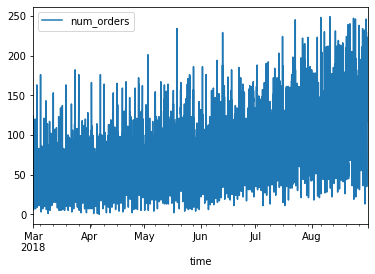

In [5]:
data.plot()

<!-- В данных были выбросы по колличеству заказов, минимальное - 0(возможна ошибка при выгрузке данных или забастовка водителей), максимальное - 462(приехала дилегация или забастовка водителей в другом таксопарке), назначив 1.5% перцентиль мы убрали данные выбросы. Судя по диаграмме, к концу лета заказов в среднем стало больше.  -->

На гистограмме видим что колличество заказов в среднем немного растет, также увеличивается среднее отклонение. 

# Обучение 

In [6]:
#Готовим данные для моделей
def make_features(data, max_log, rolling_mean_size):
    data_features = data.copy()
    data_features['month'] = data.index.month
    data_features['day'] = data.index.day
    data_features['dayofweek'] = data.index.dayofweek
    
    for i in range(1, max_log+1):
        data_features['lag_{}'.format(i)] = data_features['num_orders'].shift(i)
        
    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_features




In [7]:
# Функция для проверки на тесте
def RMSE(model):
    model.fit(features_train, target_train)
    predicted = model.predict(features_test)
    rmse_test = mean_squared_error(target_test, predicted)**0.5
    print('RMSE на тестовой выборке:', rmse_test)
    return  rmse_test

In [8]:
data_features = make_features(data, 10, 15)
data_features = data_features.dropna()

In [9]:
features_train, features_test, target_train, target_test = train_test_split(data_features.drop('num_orders', axis=1), 
                                                                            data_features['num_orders'], test_size=0.1, shuffle=False)

# features = data_features.drop('num_orders', axis=1)
# target = data_features['num_orders']

In [10]:
def LR( n_splits):
    tscv_lr = TimeSeriesSplit(n_splits=n_splits)
    rmse = make_scorer(mean_squared_error, greater_is_better=True)

    model_lr = LinearRegression()

    scores_lr = cross_val_score(model_lr, features_train, target_train, cv=tscv_lr, scoring=rmse)
    print('RMSE при кросс-валидации', scores_lr.mean()**0.5)
    return  model_lr


RMSE(LR(20))

RMSE при кросс-валидации 30.06366608549839
RMSE на тестовой выборке: 46.21555513583143


46.21555513583143

In [11]:
def RFR(n_estimators, depth, n_splits):
    model_rfr = RandomForestRegressor(n_estimators, max_depth=depth)
    tscv_rfr = TimeSeriesSplit(n_splits=n_splits)
    rmse = make_scorer(mean_squared_error, greater_is_better=True)

    scores_rfr = cross_val_score(model_rfr, features_train, target_train, cv=tscv_rfr, scoring=rmse)
  
    print('RMSE при кросс-валидации', scores_rfr.mean()**0.5)
    return  model_rfr


In [12]:
def CB ( max_depth, est, n_splits):
    model_cb = CatBoostRegressor(loss_function='RMSE', 
                              
                             depth=max_depth, 
                             learning_rate=1, verbose=10000,
                             n_estimators=est)
    tscv_cb = TimeSeriesSplit(n_splits=n_splits)
    rmse = make_scorer(mean_squared_error)

    scores_cb = cross_val_score(model_cb, features_train, target_train, cv=tscv_cb, scoring=rmse)


    print('RMSE при кросс-валидации', scores_cb.mean()**0.5)
    return  model_cb



In [13]:
def LGBM (n_estimators, max_depth, n_splits):
    model_LGBM = LGBMRegressor(max_depth=max_depth, 
                            n_estimators=120,
                            objective='regression',
                            num_leaves=1400,
                            metric='rmse')
    tscv_LGBM = TimeSeriesSplit(n_splits=n_splits)
    rmse = make_scorer(mean_squared_error)

    scores_LGBM = cross_val_score(model_LGBM, features_train, target_train, cv=tscv_LGBM, scoring=rmse)
    print('RMSE при кросс-валидации', scores_LGBM.mean()**0.5)
    return  model_LGBM



# Тестирование моделей

In [14]:
rmse_lr = RMSE(LR(100))

RMSE при кросс-валидации 29.882520904433836
RMSE на тестовой выборке: 46.21555513583143


In [15]:
rmse_rfr = RMSE(RFR(100, 10, 10))


RMSE при кросс-валидации 28.725812689830747
RMSE на тестовой выборке: 44.31099174363955


In [16]:
rmse_cb = RMSE(CB( 10, 100, 10))
# model_cb.pre


0:	learn: 22.0119593	total: 66.7ms	remaining: 6.61s
99:	learn: 0.0001876	total: 4.64s	remaining: 0us
0:	learn: 22.1047429	total: 17.1ms	remaining: 1.7s
99:	learn: 0.0043147	total: 5.16s	remaining: 0us
0:	learn: 22.8924229	total: 21.9ms	remaining: 2.17s
99:	learn: 0.0163922	total: 6.21s	remaining: 0us
0:	learn: 24.1752848	total: 55.3ms	remaining: 5.48s
99:	learn: 0.0698347	total: 6.6s	remaining: 0us
0:	learn: 23.4749079	total: 34ms	remaining: 3.37s
99:	learn: 0.1485498	total: 6.88s	remaining: 0us
0:	learn: 25.1575628	total: 25.2ms	remaining: 2.5s
99:	learn: 0.2525851	total: 8.17s	remaining: 0us
0:	learn: 26.0449424	total: 44.1ms	remaining: 4.36s
99:	learn: 0.3918304	total: 8.38s	remaining: 0us
0:	learn: 26.2530114	total: 86.7ms	remaining: 8.58s
99:	learn: 0.5729614	total: 8.54s	remaining: 0us
0:	learn: 26.4991921	total: 77ms	remaining: 7.63s
99:	learn: 0.7072325	total: 9.12s	remaining: 0us
0:	learn: 28.1320079	total: 25.6ms	remaining: 2.53s
99:	learn: 1.2423649	total: 9.29s	remaining: 0

In [17]:
rmse_lgbm = RMSE(LGBM(10, 2, 5))
# print(rmse_lgbm)


RMSE при кросс-валидации 30.15561976960824
RMSE на тестовой выборке: 46.86016950403046


             RMSE
Модель           
RFR     44.310992
LR      46.215555
LGBM    46.860170
CB      55.546554


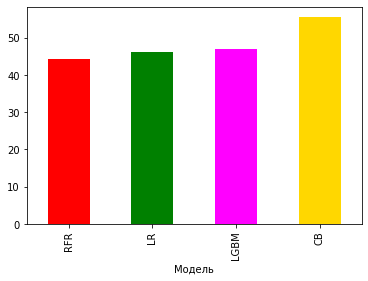

In [18]:
rmse_all = [['LR', rmse_lr], ['RFR', rmse_rfr], ['CB', rmse_cb], ['LGBM', rmse_lgbm]]
rmse_columns = ['Модель', 'RMSE']
# index=['LR', 'RFR', 'CB', 'LGBM']


rmse_data = pd.DataFrame(rmse_all, columns=rmse_columns).pivot_table(index='Модель', values='RMSE', 
                                                                     aggfunc='sum').sort_values(by='RMSE')
# rmse_data.index = index

print(rmse_data)



colors = ["red", "green", "magenta", "gold"]
rmse_data['RMSE'].plot(kind='bar', color=colors)

RMSE при кросс-валидации 28.770313958640337


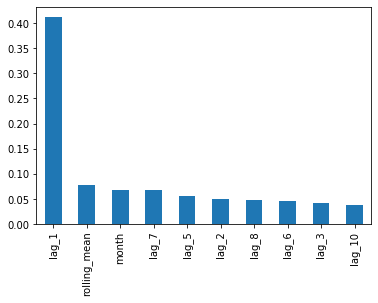

In [19]:
rfr = RFR(100, 10, 10).fit(features_train, target_train)
feat_importances = pd.Series(rfr.feature_importances_, index=features_train.columns)
feat_importances.nlargest(10).plot(kind='bar')

Из 4 обученных моделей самый  низкий(лучший) показатель RMSE показал Случайный лес, второй - Линейная регрессия, и третьей, c небольшой разницей - LGBM. При этом у первых трех  моделей  RMSE ниже  заданного. Наибольшее влияние в процессе обучения имеет признак - значения предыдущего периода, в нашем случае - это час.